In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os

# TO USE A DATABASE OTHER THAN SQLITE, USE THIS LINE
# Note that this is necessary for parallel execution amongst other things...
# os.environ['SNORKELDB'] = 'postgres:///snorkel-intro'

from snorkel import SnorkelSession
session = SnorkelSession()

# Here, we just set how many documents we'll process for automatic testing- you can safely ignore this!
n_docs = 500 if 'CI' in os.environ else 2591

from snorkel.models import candidate_subclass

Spouse = candidate_subclass('Spouse', ['person1', 'person2'])

train_cands = session.query(Spouse).filter(Spouse.split == 0).order_by(Spouse.id).all()
dev_cands   = session.query(Spouse).filter(Spouse.split == 1).order_by(Spouse.id).all()
test_cands  = session.query(Spouse).filter(Spouse.split == 2).order_by(Spouse.id).all()


In [41]:
from util import load_external_labels

%time load_external_labels(session, Spouse, annotator_name='gold')

from snorkel.annotations import load_gold_labels

#L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1, zero_one=True)
#L_gold_test = load_gold_labels(session, annotator_name='gold', split=2, zero_one=True)

L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

AnnotatorLabels created: 0
AnnotatorLabels created: 0
CPU times: user 2min 55s, sys: 2.15 s, total: 2min 57s
Wall time: 2min 57s


In [45]:
#gold_labels_dev = [x[0,0] for x in L_gold_dev.todense()]
#for i,L in enumerate(gold_labels_dev):
#    print(i,gold_labels_dev[i])

gold_labels_dev = []
for i,L in enumerate(L_gold_dev):
    gold_labels_dev.append(L[0,0])
    
gold_labels_test = []
for i,L in enumerate(L_gold_test):
    gold_labels_test.append(L[0,0])
    
print(len(gold_labels_dev),len(gold_labels_test))

(2796, 2697)


In [2]:
import gensim
gensim.scripts.glove2word2vec.glove2word2vec('../glove.6B.300d.txt', '../glove_w2v.txt')

(400000, 300)

In [15]:
from gensim.parsing.preprocessing import STOPWORDS
import gensim.matutils as gm

from gensim.models.keyedvectors import KeyedVectors

# Load pretrained model (since intermediate data is not included, the model cannot be refined with additional data)
model = KeyedVectors.load_word2vec_format('../glove_w2v.txt', binary=False)  # C binary format


wordvec_unavailable= set()
def write_to_file(wordvec_unavailable):
    with open("wordvec_unavailable.txt","w") as f:
        for word in wordvec_unavailable:
            f.write(word+"\n")

def preprocess(tokens):
    btw_words = [word for word in tokens if word not in STOPWORDS]
    btw_words = [word for word in btw_words if word.isalpha()]
    return btw_words

def get_word_vectors(btw_words): # returns vector of embeddings of words
    word_vectors= []
    for word in btw_words:
        try:
            word_v = np.array(model[word])
            word_v = word_v.reshape(len(word_v),1)
            #print(word_v.shape)
            word_vectors.append(model[word])
        except:
            wordvec_unavailable.add(word)
    return word_vectors

def get_similarity(word_vectors,target_word): # sent(list of word vecs) to word similarity
    similarity = 0
    target_word_vector = 0
    try:
        target_word_vector = model[target_word]
    except:
        wordvec_unavailable.add(target_word+" t")
        return similarity
    target_word_sparse = gm.any2sparse(target_word_vector,eps=1e-09)
    for wv in word_vectors:
        wv_sparse = gm.any2sparse(wv, eps=1e-09)
        similarity = max(similarity,gm.cossim(wv_sparse,target_word_sparse))
    return similarity


In [122]:
##### Continuous ################

import re
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)


spouses = {'spouse', 'wife', 'husband', 'ex-wife', 'ex-husband'}
family = {'father', 'mother', 'sister', 'brother', 'son', 'daughter',
              'grandfather', 'grandmother', 'uncle', 'aunt', 'cousin'}
family = family | {f + '-in-law' for f in family}
other = {'boyfriend', 'girlfriend' 'boss', 'employee', 'secretary', 'co-worker'}

# Helper function to get last name
def last_name(s):
    name_parts = s.split(' ')
    return name_parts[-1] if len(name_parts) > 1 else None    

def LF_husband_wife(c):
    sc = 0
    word_vectors = get_word_vectors(preprocess(get_between_tokens(c)))
    for sw in spouses:
        sc=max(sc,get_similarity(word_vectors,sw))
    if sc<0.8:
        return (0,0)
    return (1,sc)

def LF_husband_wife_left_window(c):
    sc_1 = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c[0])))
    for sw in spouses:
        sc_1=max(sc_1,get_similarity(word_vectors,sw))
        
    sc_2 = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c[1])))
    for sw in spouses:
        sc_2=max(sc_2,get_similarity(word_vectors,sw))
        
    return(1,max(sc_1,sc_2))
    
def LF_same_last_name(c):
    p1_last_name = last_name(c.person1.get_span())
    p2_last_name = last_name(c.person2.get_span())
    if p1_last_name and p2_last_name and p1_last_name == p2_last_name:
        if c.person1.get_span() != c.person2.get_span():
            return (1,1)
    return (0,0)

def LF_no_spouse_in_sentence(c):
    return (-1,0.75) if np.random.rand() < 0.75 and len(spouses.intersection(c.get_parent().words)) == 0 else (0,0)

def LF_and_married(c):
    word_vectors = get_word_vectors(preprocess(get_right_tokens(c)))
    sc = get_similarity(word_vectors,'married')
    if sc<0.7:
        return (0,0)
    if 'and' in get_between_tokens(c):
        return (1,sc)
    else:
        return (0,0)

def LF_familial_relationship(c):
    sc = 0
    word_vectors = get_word_vectors(preprocess(get_between_tokens(c)))
    for fw in family:
        sc=max(sc,get_similarity(word_vectors,fw))
    return (-1,sc) 

def LF_family_left_window(c):
    sc_1 = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c[0])))
    for fw in family:
        sc_1=max(sc_1,get_similarity(word_vectors,fw))
        
    sc_2 = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c[1])))
    for fw in family:
        sc_2=max(sc_2,get_similarity(word_vectors,fw))
    return (-1,max(sc_1,sc_2))

def LF_other_relationship(c):
    sc = 0
    word_vectors = get_word_vectors(preprocess(get_between_tokens(c)))
    for ow in other:
        sc=max(sc,get_similarity(word_vectors,ow))
    return (-1,sc) 

def LF_other_relationship_left_window(c):
    sc = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c)))
    for ow in other:
        sc=max(sc,get_similarity(word_vectors,ow))
    return (-1,sc) 

import bz2

# Function to remove special characters from text
def strip_special(s):
    return ''.join(c for c in s if ord(c) < 128)

# Read in known spouse pairs and save as set of tuples
with bz2.BZ2File('data/spouses_dbpedia.csv.bz2', 'rb') as f:
    known_spouses = set(
        tuple(strip_special(x).strip().split(',')) for x in f.readlines()
    )
# Last name pairs for known spouses
last_names = set([(last_name(x), last_name(y)) for x, y in known_spouses if last_name(x) and last_name(y)])
    
def LF_distant_supervision(c):
    p1, p2 = c.person1.get_span(), c.person2.get_span()
    return (1,1) if (p1, p2) in known_spouses or (p2, p1) in known_spouses else (0,0)

def LF_distant_supervision_last_names(c):
    p1, p2 = c.person1.get_span(), c.person2.get_span()
    p1n, p2n = last_name(p1), last_name(p2)
    return (1,1) if (p1 != p2) and ((p1n, p2n) in last_names or (p2n, p1n) in last_names) else (0,1)

import numpy as np

def LF_Three_Lists_Left_Window(c):
    c1,s1 = LF_husband_wife_left_window(c)
    c2,s2 = LF_family_left_window(c)
    c3,s3 = LF_other_relationship_left_window(c)
    sc = np.array([s1,s2,s3])
    c = [c1,c2,c3]
    sharp_param = 1.5
    prob_sc = np.exp(sc * sharp_param - np.max(sc))
    prob_sc = prob_sc / np.sum(prob_sc)
    #print 'Left:',s1,s2,s3,prob_sc
    
    if s1==s2 or s3==s1 or np.max(sc)<0.5:
        return (0,0)
    return c[np.argmax(prob_sc)],1

def LF_Three_Lists_Between_Words(c):
    c1,s1 = LF_husband_wife(c)
    c2,s2 = LF_familial_relationship(c)
    c3,s3 = LF_other_relationship(c)
    sc = np.array([s1,s2,s3])
    c = [c1,c2,c3]
    sharp_param = 1.5
    
    prob_sc = np.exp(sc * sharp_param - np.max(sc))
    prob_sc = prob_sc / np.sum(prob_sc)
    #print 'BW:',s1,s2,s3,prob_sc
    #if s1==s2 or s3==s1 or np.max(sc)<0.5:
    #    return (0,0)
    return c[np.argmax(prob_sc)],1
    
LFs = [LF_distant_supervision, LF_distant_supervision_last_names,LF_same_last_name,
       LF_and_married, LF_Three_Lists_Between_Words,LF_Three_Lists_Left_Window
      ]

In [168]:
import re
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)


spouses = {'spouse', 'wife', 'husband', 'ex-wife', 'ex-husband'}
family = {'father', 'mother', 'sister', 'brother', 'son', 'daughter',
              'grandfather', 'grandmother', 'uncle', 'aunt', 'cousin'}
family = family | {f + '-in-law' for f in family}
other = {'boyfriend', 'girlfriend' 'boss', 'employee', 'secretary', 'co-worker'}

# Helper function to get last name
def last_name(s):
    name_parts = s.split(' ')
    return name_parts[-1] if len(name_parts) > 1 else None    

def LF_husband_wife(c):
    return (1,1) if len(spouses.intersection(get_between_tokens(c))) > 0 else (0,1)

def LF_husband_wife_left_window(c):
    if len(spouses.intersection(get_left_tokens(c[0], window=2))) > 0:
        return (1,1)
    elif len(spouses.intersection(get_left_tokens(c[1], window=2))) > 0:
        return (1,1)
    else:
        return (0,1)
    
def LF_same_last_name(c):
    p1_last_name = last_name(c.person1.get_span())
    p2_last_name = last_name(c.person2.get_span())
    if p1_last_name and p2_last_name and p1_last_name == p2_last_name:
        if c.person1.get_span() != c.person2.get_span():
            return (1,1)
    return (0,1)

def LF_no_spouse_in_sentence(c):
    return (-1,1) if np.random.rand() < 0.75 and len(spouses.intersection(c.get_parent().words)) == 0 else (0,1)

def LF_and_married(c):
    return (1,1) if 'and' in get_between_tokens(c) and 'married' in get_right_tokens(c) else (0,1)
    
def LF_familial_relationship(c):
    return (-1,1) if len(family.intersection(get_between_tokens(c))) > 0 else (0,1)

def LF_family_left_window(c):
    if len(family.intersection(get_left_tokens(c[0], window=2))) > 0:
        return (-1,1)
    elif len(family.intersection(get_left_tokens(c[1], window=2))) > 0:
        return (-1,1)
    else:
        return (0,1)

def LF_other_relationship(c):
    return (-1,1) if len(other.intersection(get_between_tokens(c))) > 0 else (0,1)


import bz2

# Function to remove special characters from text
def strip_special(s):
    return ''.join(c for c in s if ord(c) < 128)

# Read in known spouse pairs and save as set of tuples
with bz2.BZ2File('data/spouses_dbpedia.csv.bz2', 'rb') as f:
    known_spouses = set(
        tuple(strip_special(x).strip().split(',')) for x in f.readlines()
    )
# Last name pairs for known spouses
last_names = set([(last_name(x), last_name(y)) for x, y in known_spouses if last_name(x) and last_name(y)])
    
def LF_distant_supervision(c):
    p1, p2 = c.person1.get_span(), c.person2.get_span()
    return (1,1) if (p1, p2) in known_spouses or (p2, p1) in known_spouses else (0,1)

def LF_distant_supervision_last_names(c):
    p1, p2 = c.person1.get_span(), c.person2.get_span()
    p1n, p2n = last_name(p1), last_name(p2)
    return (1,1) if (p1 != p2) and ((p1n, p2n) in last_names or (p2n, p1n) in last_names) else (0,1)

In [169]:
def LF_Three_Lists_Between_Words(c):
    c1,s1 = LF_husband_wife(c)
    c2,s2 = LF_familial_relationship(c)
    c3,s3 = LF_other_relationship(c)
    sc = np.array([s1,s2,s3])
    c = [c1,c2,c3]
    sharp_param = 1.5
    
    prob_sc = np.exp(sc * sharp_param - np.max(sc))
    prob_sc = prob_sc / np.sum(prob_sc)
    #print 'BW:',s1,s2,s3,prob_sc
    #if s1==s2 or s3==s1 or np.max(sc)<0.5:
    #    return (0,0)
    return c[np.argmax(prob_sc)],1

In [170]:
LFs = [
    LF_distant_supervision, LF_distant_supervision_last_names, 
    LF_husband_wife, LF_husband_wife_left_window, LF_same_last_name,
    LF_no_spouse_in_sentence, LF_and_married, LF_familial_relationship, 
    LF_family_left_window, LF_other_relationship, LF_Three_Lists_Between_Words
]

In [164]:
LFs = [
    LF_distant_supervision, LF_distant_supervision_last_names, 
    LF_husband_wife_left_window, LF_same_last_name,
    LF_no_spouse_in_sentence, LF_and_married, 
    LF_family_left_window, LF_Three_Lists_Between_Words
]

In [171]:

import numpy as np
import math

def PHI(K,LAMDAi,SCOREi):
    return [K*l*s for (l,s) in zip(LAMDAi,SCOREi)]

def softmax(THETA,LAMDAi,SCOREi):
    x = []
    for k in [1,-1]:
        product = np.dot(PHI(k,LAMDAi,SCOREi),THETA)
        x.append(product)
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def function_conf(THETA,LAMDA,P_cap,Confidence):
    s = 0.0
    i = 0
    for LAMDAi in LAMDA:
        s = s + Confidence[i]*np.dot(np.log(softmax(THETA,LAMDAi)),P_cap[i])
        i = i+1
    return -s

def function(THETA,LAMDA,SCORE,P_cap):
    s = 0.0
    i = 0
    for i in range(len(LAMDA)):
        s = s + np.dot(np.log(softmax(THETA,LAMDA[i],SCORE[i])),P_cap[i])
        i = i+1
    return -s

def P_K_Given_LAMDAi_THETA(K,THETA,LAMDAi,SCOREi):
    x = softmax(THETA,LAMDAi,SCOREi)
    if(K==1):
        return x[0]
    else:
        return x[1]
      

np.random.seed(78)
THETA = np.random.rand(len(LFs),1)

def PHIj(j,K,LAMDAi,SCOREi):
    return LAMDAi[j]*K*SCOREi[j]

def RIGHT(j,LAMDAi,SCOREi,THETA):
    phi = []
    for k in [1,-1]:
        phi.append(PHIj(j,k,LAMDAi,SCOREi))
    x = softmax(THETA,LAMDAi,SCOREi)
    return np.dot(phi,x)
    

def function_conf_der(THETA,LAMDA,P_cap,Confidence):
    der = []
    for j in range(len(THETA)):
        i = 0
        s = 0.0
        for LAMDAi in LAMDA:
            p = 0
            for K in [1,-1]:
                s = s + Confidence[i]*(PHIj(j,K,LAMDAi)-RIGHT(j,LAMDAi,THETA))*P_cap[i][p]
                p = p+1
            i = i+1
        der.append(-s)
    return np.array(der)

def function_der(THETA,LAMDA,SCORE,P_cap):
    der = []
    for j in range(len(THETA)):
        i = 0
        s = 0.0
        for index in range(len(LAMDA)):
            p = 0
            for K in [1,-1]:
                s = s + (PHIj(j,K,LAMDA[index],SCORE[index])-RIGHT(j,LAMDA[index],SCORE[index],THETA))*P_cap[i][p]
                p = p+1
            i = i+1
        der.append(-s)
    return np.array(der)


import numpy as np


def get_LAMDA(cands):
    LAMDA = []
    SCORE = []
    for ci in cands:
        L=[]
        S=[]
        P_ik = []
        for LF in LFs:
            #print LF.__name__
            l,s = LF(ci)
            L.append(l)
            S.append((s+1)/2)  #to scale scores in [0,1] 
        LAMDA.append(L)
        SCORE.append(S) 
    return LAMDA,SCORE

def get_Confidence(LAMDA):
    confidence = []
    for L in LAMDA:
        Total_L = float(len(L))
        No_zeros = L.count(0)
        No_Non_Zeros = Total_L - No_zeros
        confidence.append(No_Non_Zeros/Total_L)
    return confidence    
    
def get_Initial_P_cap(LAMDA):
    P_cap = []
    for L in LAMDA:
        P_ik = []
        denominator=float(L.count(1)+L.count(-1))
        if(denominator==0):
            denominator=1
        P_ik.append(L.count(1)/denominator)
        P_ik.append(L.count(-1)/denominator)
        P_cap.append(P_ik)
    return P_cap
    #print(np.array(LAMDA))
    #print(np.array(P_cap))append(L)
    #LAMDA=np.array(LAMDA).astype(int)
    #P_cap=np.array(P_cap)
    #print(np.array(LAMDA).shape)
    #print(np.array(P_cap).shape)
    #print(L)
    #print(ci.chemical.get_span(),ci.disease.get_span(),"No.Os",L.count(0),"No.1s",L.count(1),"No.-1s",L.count(-1))
    #print(ci.chemical.get_span(),ci.disease.get_span(),"P(0):",L.count(0)/len(L)," P(1)",L.count(1)/len(L),"P(-1)",L.count(-1)/len(L))

        
def get_P_cap(LAMDA,SCORE,THETA):
    P_cap = []
    for i in range(len(LAMDA)):
        P_capi = softmax(THETA,LAMDA[i],SCORE[i])
        P_cap.append(P_capi)
    return P_cap


def score(predicted_labels,gold_labels):
    tp =0.0
    tn =0.0
    fp =0.0
    fn =0.0
    for i in range(len(gold_labels)):
        if(predicted_labels[i]==gold_labels[i]):
            if(predicted_labels[i]==1):
                tp=tp+1
            else:
                tn=tn+1
        else:
            if(predicted_labels[i]==1):
                fp=fp+1
            else:
                fn=fn+1
    print("tp",tp,"tn",tn,"fp",fp,"fn",fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1score = (2*precision*recall)/(precision+recall)
    print("precision:",precision)
    print("recall:",recall)
    print("F1 score:",f1score)
                
           
    
from scipy.optimize import minimize
import cPickle as pickle

def get_marginals(P_cap):
    marginals = []
    for P_capi in P_cap:
        marginals.append(P_capi[0])
    return marginals

def predict_labels(marginals):
    predicted_labels=[]
    for i in marginals:
        if(i<0.5):
            predicted_labels.append(-1)
        else:
            predicted_labels.append(1)
    return predicted_labels

def print_details(label,THETA,LAMDA,SCORE):
    print(label)
    P_cap = get_P_cap(LAMDA,SCORE,THETA)
    marginals=get_marginals(P_cap)
    plt.hist(marginals, bins=20)
    plt.show()
    plt.bar(range(0,2796),marginals)
    plt.show()
    predicted_labels=predict_labels(marginals)
    print(len(marginals),len(predicted_labels),len(gold_labels_dev))
    #score(predicted_labels,gold_labels_dev)
    print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary')) 
    
    
    
def train(No_Iter,Use_Confidence=True,theta_file_name="THETA"):
    global THETA
    global dev_LAMDA,dev_SCORE
    LAMDA,SCORE = get_LAMDA(train_cands)
    P_cap = get_Initial_P_cap(LAMDA)
    Confidence = get_Confidence(LAMDA)
    for iteration in range(No_Iter):
        if(Use_Confidence==True):
            res = minimize(function_conf,THETA,args=(LAMDA,P_cap,Confidence), method='BFGS',jac=function_conf_der,options={'disp': True, 'maxiter':20}) #nelder-mead
        else:
            res = minimize(function,THETA,args=(LAMDA,SCORE,P_cap), method='BFGS',jac=function_der,options={'disp': True, 'maxiter':20}) #nelder-mead            
        THETA = res.x # new THETA
        print(THETA)
        P_cap = get_P_cap(LAMDA,SCORE,THETA) #new p_cap 
        print_details("train iteration: "+str(iteration),THETA,dev_LAMDA,dev_SCORE)
        #score(predicted_labels,gold_labels)
    NP_P_cap = np.array(P_cap)
    np.savetxt('Train_P_cap.txt', NP_P_cap, fmt='%f')
    pickle.dump(NP_P_cap,open("Train_P_cap.p","wb"))
    NP_THETA = np.array(THETA)
    np.savetxt(theta_file_name+'.txt', NP_THETA, fmt='%f') 
    pickle.dump( NP_THETA, open( theta_file_name+'.p', "wb" )) # save the file as "outfile_name.npy" 

        
def test(THETA):
    global dev_LAMDA,dev_SCORE
    P_cap = get_P_cap(dev_LAMDA,dev_SCORE,THETA)
    print_details("test:",THETA,dev_LAMDA,dev_SCORE)
    NP_P_cap = np.array(P_cap)
    np.savetxt('Dev_P_cap.txt', NP_P_cap, fmt='%f')
    pickle.dump(NP_P_cap,open("Dev_P_cap.p","wb"))
                    
def load_marginals(s):
    marginals = []
    if(s=="train"):
        train_P_cap = np.load("Train_P_cap.npy")
        marginals = train_P_cap[:,0]
    return marginals



In [172]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
    
dev_LAMDA,dev_SCORE = get_LAMDA(dev_cands)

write_to_file(wordvec_unavailable)

         Current function value: 743.703827
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
[ 2.60658269  0.99612125  1.06314207  1.51112721  2.94819461  3.19066907
  3.18338284  1.59491094  0.93110994  1.85817376  0.91468376]
train iteration: 0


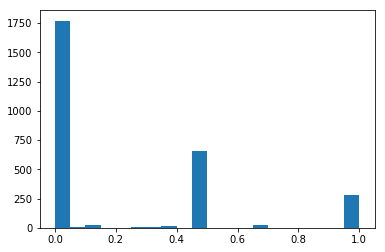

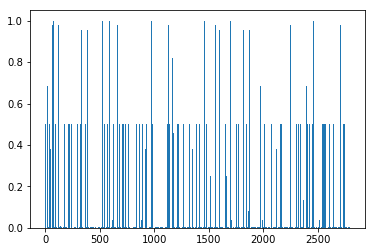

(2796, 2796, 2796)
(0.14391534391534391, 0.69387755102040816, 0.23838737949167396, None)
Optimization terminated successfully.
         Current function value: 4228.708923
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 2.60658269  0.99612125  1.06314207  1.51112721  2.94819461  3.19066907
  3.18338284  1.59491094  0.93110994  1.85817376  0.91468376]
train iteration: 1


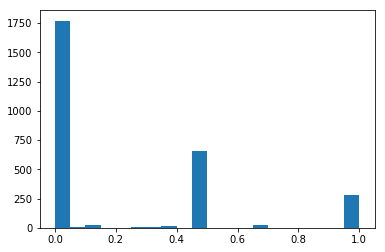

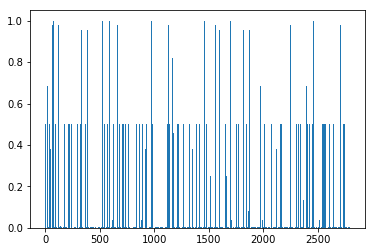

(2796, 2796, 2796)
(0.14391534391534391, 0.69387755102040816, 0.23838737949167396, None)
Optimization terminated successfully.
         Current function value: 4228.708923
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 2.60658269  0.99612125  1.06314207  1.51112721  2.94819461  3.19066907
  3.18338284  1.59491094  0.93110994  1.85817376  0.91468376]
train iteration: 2


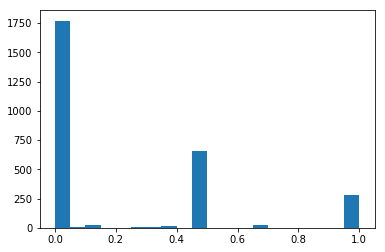

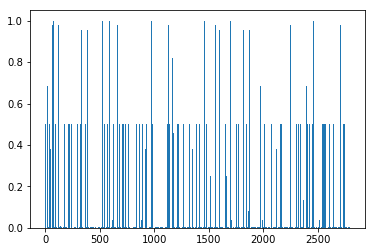

(2796, 2796, 2796)
(0.14391534391534391, 0.69387755102040816, 0.23838737949167396, None)
test:


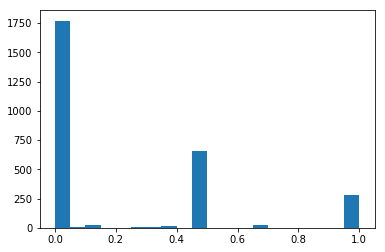

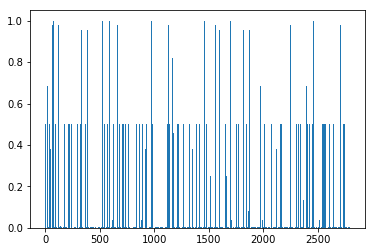

(2796, 2796, 2796)
(0.14391534391534391, 0.69387755102040816, 0.23838737949167396, None)


In [173]:
# with Three lists between nothing removed

train(3,Use_Confidence=False,theta_file_name="Three_lists_between_THETA")

test(THETA)

         Current function value: 555.304150
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
[ 2.90673907  0.92113767  2.01434713  3.44313336  3.43945515  3.43244584
  1.73715335  1.73565105]
train iteration: 0


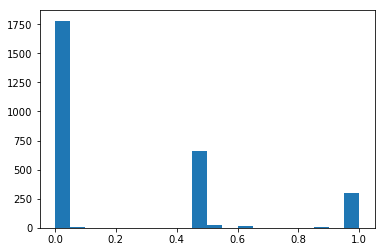

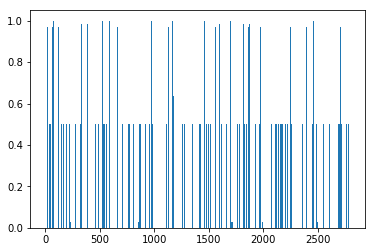

(2796, 2796, 2796)
(0.1443089430894309, 0.72448979591836737, 0.24067796610169492, None)
Optimization terminated successfully.
         Current function value: 4064.612286
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 2.90673907  0.92113767  2.01434713  3.44313336  3.43945515  3.43244584
  1.73715335  1.73565105]
train iteration: 1


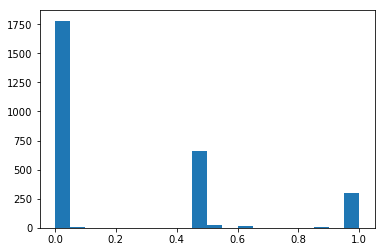

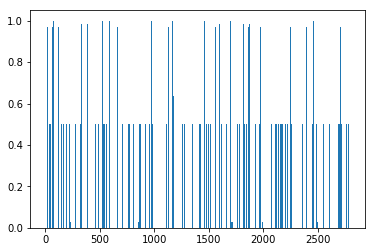

(2796, 2796, 2796)
(0.1443089430894309, 0.72448979591836737, 0.24067796610169492, None)
Optimization terminated successfully.
         Current function value: 4064.612286
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 2.90673907  0.92113767  2.01434713  3.44313336  3.43945515  3.43244584
  1.73715335  1.73565105]
train iteration: 2


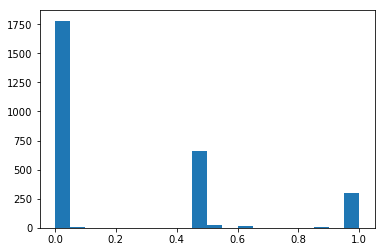

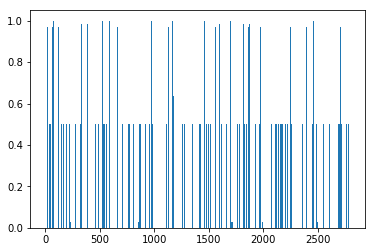

(2796, 2796, 2796)
(0.1443089430894309, 0.72448979591836737, 0.24067796610169492, None)
test:


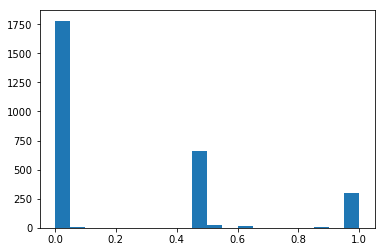

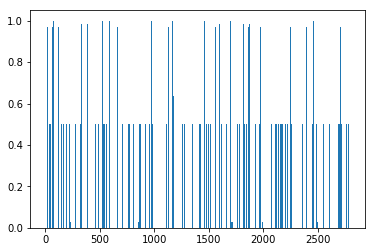

(2796, 2796, 2796)
(0.1443089430894309, 0.72448979591836737, 0.24067796610169492, None)


In [167]:
# with Three lists between and removed husband_wife,familial_relationship,other_relationship
# of only between words

train(3,Use_Confidence=False,theta_file_name="Three_lists_between_THETA")

test(THETA)

         Current function value: 1789.538836
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
[ 1.68662141  0.80240763  1.85977757  1.01891484  1.95826754  2.13835698
  2.13103508  1.08483367  0.91678402  1.59058604]
train iteration: 0


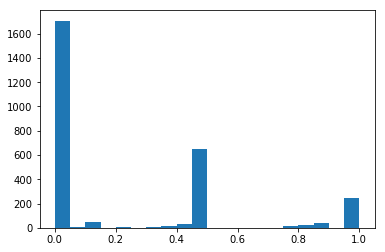

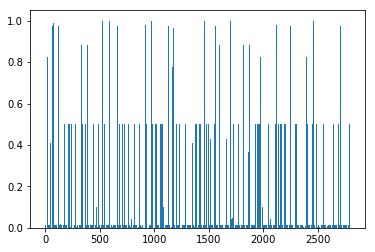

(2796, 2796, 2796)
(0.14447884416924664, 0.7142857142857143, 0.24034334763948498, None)
Optimization terminated successfully.
         Current function value: 5253.895230
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 1.68662141  0.80240763  1.85977757  1.01891484  1.95826754  2.13835698
  2.13103508  1.08483367  0.91678402  1.59058604]
train iteration: 1


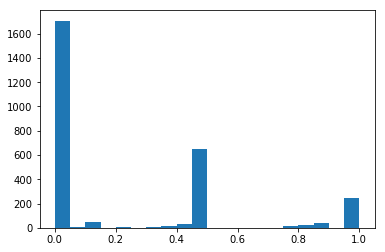

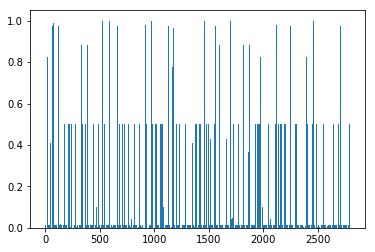

(2796, 2796, 2796)
(0.14447884416924664, 0.7142857142857143, 0.24034334763948498, None)
Optimization terminated successfully.
         Current function value: 5253.895230
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 1.68662141  0.80240763  1.85977757  1.01891484  1.95826754  2.13835698
  2.13103508  1.08483367  0.91678402  1.59058604]
train iteration: 2


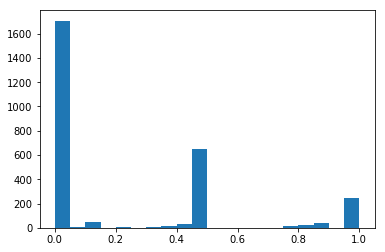

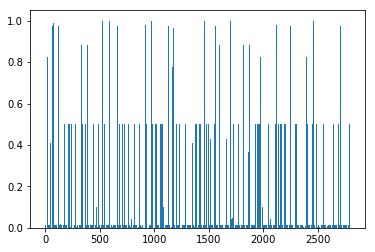

(2796, 2796, 2796)
(0.14447884416924664, 0.7142857142857143, 0.24034334763948498, None)
test:


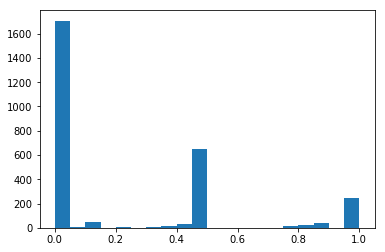

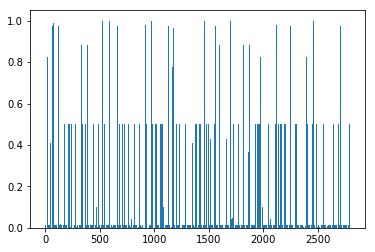

(2796, 2796, 2796)
(0.14447884416924664, 0.7142857142857143, 0.24034334763948498, None)


In [161]:
# except LF_husband_wife

train(3,Use_Confidence=False,theta_file_name="THETA")

test(THETA)

         Current function value: 780.551846
         Iterations: 15
         Function evaluations: 116
         Gradient evaluations: 105
[ 2.64885233  0.92447944  1.65703998  1.43595789  3.08230419  3.21147275
  3.20381711  1.61237953  1.03295399  1.8688803 ]
train iteration: 0


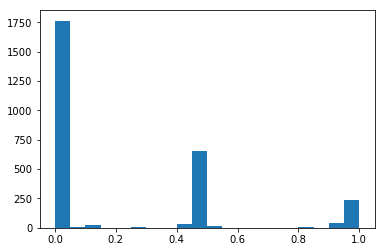

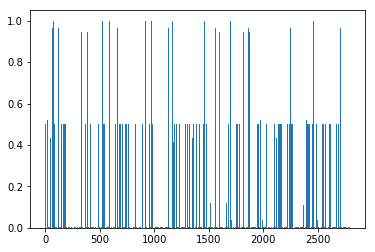

(2796, 2796, 2796)
(0.15132275132275133, 0.72959183673469385, 0.25065731814198072, None)
Optimization terminated successfully.
         Current function value: 4296.194189
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 2.64885233  0.92447944  1.65703998  1.43595789  3.08230419  3.21147275
  3.20381711  1.61237953  1.03295399  1.8688803 ]
train iteration: 1


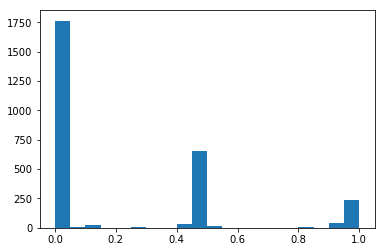

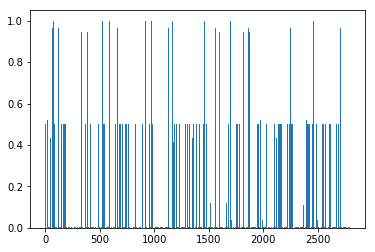

(2796, 2796, 2796)
(0.15132275132275133, 0.72959183673469385, 0.25065731814198072, None)
Optimization terminated successfully.
         Current function value: 4296.194189
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 2.64885233  0.92447944  1.65703998  1.43595789  3.08230419  3.21147275
  3.20381711  1.61237953  1.03295399  1.8688803 ]
train iteration: 2


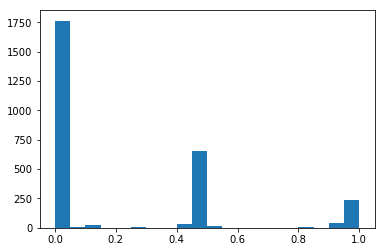

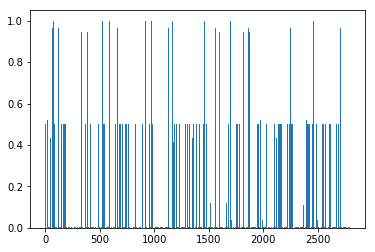

(2796, 2796, 2796)
(0.15132275132275133, 0.72959183673469385, 0.25065731814198072, None)
test:


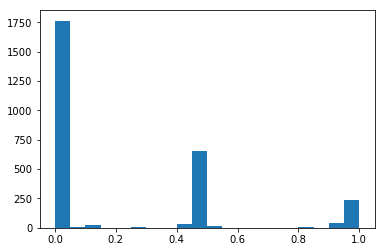

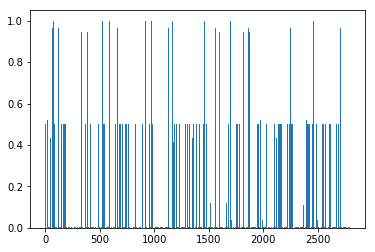

(2796, 2796, 2796)
(0.15132275132275133, 0.72959183673469385, 0.25065731814198072, None)


In [155]:
#All are descrete

train(3,Use_Confidence=False,"THETA")

test(THETA)

dev set


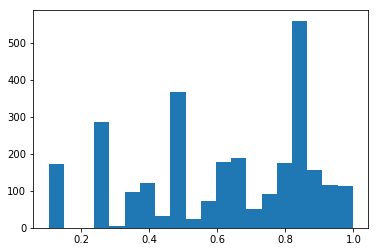

(2796, 2796, 2796)
(0.082104228121927234, 0.85204081632653061, 0.14977578475336323, None)
0 (1.0, 1, 1)
1 (0.8333333333333334, 1, 1)
2 (0.8333333333333334, 1, 1)
3 (0.8333333333333334, 1, 1)
4 (0.8333333333333334, 1, -1)
5 (0.8333333333333334, 1, -1)
6 (0.8333333333333334, 1, -1)
7 (0.8333333333333334, -1, 1)
8 (0.8333333333333334, -1, -1)
9 (0.6666666666666666, 1, 1)
10 (0.6666666666666666, 1, 1)
11 (0.6666666666666666, 1, 1)
12 (0.6666666666666666, 1, 1)
13 (0.6666666666666666, 1, 1)
14 (0.6666666666666666, 1, 1)
15 (0.6666666666666666, 1, 1)
16 (0.6666666666666666, 1, 1)
17 (0.6666666666666666, 1, -1)
18 (0.6666666666666666, 1, -1)
19 (0.6666666666666666, 1, -1)
20 (0.6666666666666666, 1, -1)
('tp', 167.0, 'tn', 733.0, 'fp', 1867.0, 'fn', 29.0)
('precision:', 0.08210422812192723)
('recall:', 0.8520408163265306)
('F1 score:', 0.14977578475336323)


In [76]:
def print_details(label,THETA,LAMDA,SCORE):
    print(label)
    P_cap = get_P_cap(LAMDA,SCORE,THETA)
    marginals=get_marginals(P_cap)
    plt.hist(marginals, bins=20)
    plt.show()
    #plt.bar(range(0,2796),marginals)
    #plt.show()
    predicted_labels=predict_labels(marginals)
    print(len(marginals),len(predicted_labels),len(gold_labels_dev))
    #score(predicted_labels,gold_labels_dev)
    print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary')) 
    
def predict_labels(marginals):
    predicted_labels=[]
    for i in marginals:
        if(i<0.5):
            predicted_labels.append(-1)
        else:
            predicted_labels.append(1)
    return predicted_labels

#import cPickle as pickle
#THETA = pickle.load( open( "THETA.p", "rb" ) )
#test(THETA)
#LAMDA,SCORE = get_LAMDA(dev_cands)
#Confidence = get_Confidence(LAMDA)

#P_cap = get_P_cap(LAMDA,SCORE,THETA)
#marginals=get_marginals(P_cap)
#plt.hist(marginals, bins=20)
#plt.show()
#plt.bar(range(0,888),train_marginals)
#plt.show()

print_details("dev set",THETA,dev_LAMDA,dev_SCORE)
predicted_labels=predict_labels(marginals)


sorted_predicted_labels=[x for (y,x) in sorted(zip(Confidence,predicted_labels))] #sort Labels as per Confidence
sorted_predicted_labels=list(reversed(sorted_predicted_labels))


for i,j in enumerate(reversed(sorted(zip(Confidence,predicted_labels,gold_labels_dev)))):
    if i>20:
        break
    print i,j
#print(len(marginals),len(predicted_labels),len(gold_labels_dev))
#no_of_labels=186#int(len(predicted_labels)*0.1)  #54 - >0.2  , 108>= 0.15 , 186>= 0.12
#print(len(sorted_predicted_labels[0:no_of_labels]))
no_of_labels=2796
score(predicted_labels[0:no_of_labels],gold_labels_dev[0:no_of_labels])
